In [113]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [114]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os
from matplotlib.pyplot import hist

In [115]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

In [116]:
x = pd.read_stata("maindata.dta", convert_categoricals=False)
laws_csv = pd.read_csv("When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.drop("State_Name", axis=1)  # Dropping as useless
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

In [124]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think
#age_subset = np.logical_and(np.greater_equal(basic_merged["a_age"],18), np.greater_equal(19,basic_merged["a_age"]))
# 17 <= age <= 21 (maybe should be like 22)
#basic_merged = basic_merged[age_subset]
#print(basic_merged.shape)

# Dropping states who were treated < 97 (i.e. they always had programs)
# This is following Callaway + Sant'anna, as we cannot meaningfully 
# do any inference using those states. Although we can compare them later as a 
# robustness check, which may be interesting
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# I also drop the never states, as they may be substantively different from others, although this can be relaxed later.
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to intbasic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("never")==False]  # Only want to look at one for now. 

# As we are treating >19 as the never-treated group, we set their year implemented as 1000000 >> 1999
year_implemented_vector = basic_merged["Year_Implemented"].copy()
year_implemented_vector[basic_merged["under19"] == 0] = 1000000
basic_merged["group"] = year_implemented_vector  # Equals the year you were first treated. If >=19 then treated at t = infty

# Drop Arizona since they implemented late and later repealed policy
basic_merged = basic_merged[basic_merged["stfips"] != 5]

# Generating list of confounders of interest, these are not necessarily optimal. 
list_of_confounders = ["fownu18", "a_maritl", "female" , "povll"]#, "stfips"]
list_of_confounders += ["anykids", "disability", "collgrad", "hsgrad"] # coll + hs are extra for now. 

In [157]:
def make_g_model():
  return sklearn.ensemble.GradientBoostingClassifier()

In [127]:
def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
      X_train = X.loc[train_index]
      A_train = A.loc[train_index]
      g = make_model()
      g.fit(X_train, A_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions

In [128]:
#overlap and g scores are calculated as the probabiliy that the indiviual is treated (under 19) in treated year given
#that you were either in that state in 1997 or never treated at all (over age of 19)
def calculate_g(treated_year):
    sub_merged = basic_merged.copy()
    
    #data of indiviuals 
    sub_merged = sub_merged[(sub_merged["group"] == treated_year) | (sub_merged["group"] == 1000000)]
    
    treatment_bin = {treated_year: 1, 1000000: 0}
    sub_merged.group = [treatment_bin[item] for item in sub_merged.group]
    sub_merged = sub_merged.reset_index()
    
    treatment = sub_merged["group"]
    confounders = sub_merged[list_of_confounders]
    
    g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=10)
    
    return g
    

(array([9.87453270e+00, 4.14058788e-01, 2.20641962e-02, 1.10699765e-01,
        1.15273588e+00, 3.79731445e-02, 5.01700048e-01, 6.57333123e-01,
        1.31817000e-01, 4.35602156e-03]),
 array([0.        , 0.07747571, 0.15495143, 0.23242714, 0.30990285,
        0.38737857, 0.46485428, 0.54232999, 0.61980571, 0.69728142,
        0.77475713]),
 <a list of 10 Patch objects>)

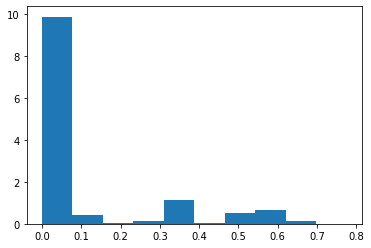

In [129]:
g1 = calculate_g(1997)
hist(g1, density=True)

In [137]:
g1.max()

0.7747571319209327

(array([3.63185619, 1.75280095, 0.94416622, 0.29760142, 0.00621291,
        0.00697196, 0.03320114, 1.64220544, 0.50015368, 1.91616405]),
 array([8.15569763e-04, 9.40006298e-02, 1.87185690e-01, 2.80370750e-01,
        3.73555810e-01, 4.66740870e-01, 5.59925930e-01, 6.53110990e-01,
        7.46296050e-01, 8.39481110e-01, 9.32666170e-01]),
 <a list of 10 Patch objects>)

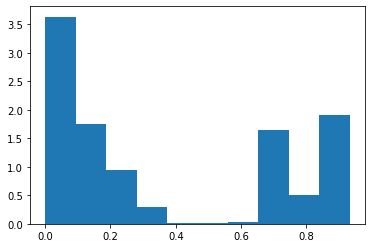

In [158]:
g2 = calculate_g(1998)
hist(g2, density=True)

In [159]:
g2.max()

0.932666170478082

(array([8.52532751, 0.99057759, 0.04205426, 0.01490146, 0.01955002,
        1.30316062, 0.1066562 , 0.35216095, 1.08624233, 0.15314179]),
 array([0.        , 0.07940432, 0.15880865, 0.23821297, 0.31761729,
        0.39702162, 0.47642594, 0.55583026, 0.63523459, 0.71463891,
        0.79404323]),
 <a list of 10 Patch objects>)

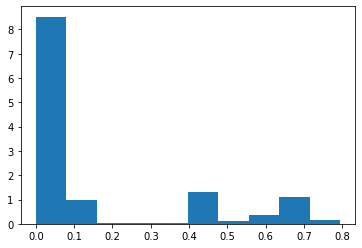

In [131]:
g3 = calculate_g(1999)
hist(g3, density=True)

In [139]:
g3.max()

0.7940432327273385

In [132]:
def fit_g(treated_year, g_model):
    sub_merged = basic_merged.copy()
    sub_merged = sub_merged[(sub_merged["group"] == treated_year) | (sub_merged["group"] == 1000000)]
    
    treatment_bin = {treated_year: 1, 1000000: 0}
    sub_merged.group = [treatment_bin[item] for item in sub_merged.group]
    sub_merged = sub_merged.reset_index()
    
    treatment = sub_merged["group"]
    confounders = sub_merged[list_of_confounders]
    
    x_train, x_test, a_train, a_test = train_test_split(confounders, treatment, test_size=0.2)
    g_model.fit(x_train, a_train)
    a_pred = g_model.predict_proba(x_test)[:,1]
    
    test_ce=log_loss(a_test, a_pred)
    baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
    score = g_model.score(x_test,a_test)
    
    return test_ce, baseline_ce, score

In [145]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

Rf_depth_2 = RandomForestClassifier(n_estimators=100, max_depth=2)
Rf_depth_10 = RandomForestClassifier(n_estimators=100, max_depth=10)
KNN = KNeighborsClassifier()
LogReg = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
XGBoost = sklearn.ensemble.GradientBoostingClassifier()

models = [Rf_depth_2, Rf_depth_10, KNN, LogReg, XGBoost]

In [146]:
def fit_year(treated_year, models):
    fit_stat = pd.DataFrame()
    model_lst = ["Rf_depth2", "RF_depth10", "KNN", "LogReg", "XGBoost"]
    g_ce = []
    score = []
    baseline = []

    for model in models:
        x, y, z = fit_g(treated_year, model)
        g_ce.append(x)
        baseline.append(y)
        score.append(z)

    fit_stat["model"] = model_lst
    fit_stat["g_ce"] = g_ce
    fit_stat["baseline_ce"] = baseline
    fit_stat["accuracy_score"] = score

    return fit_stat

In [147]:
fit_year(1997, models)

,model,g_ce,baseline_ce,accuracy_score
0,Rf_depth2,0.283902,0.346638,0.889951
1,RF_depth10,0.213491,0.350360,0.906568
2,KNN,1.000770,0.351579,0.885347
3,LogReg,0.229034,0.351236,0.899121
4,XGBoost,0.216690,0.355592,0.904404


In [152]:
fit_year(1998, models)

,model,g_ce,baseline_ce,accuracy_score
0,Rf_depth2,0.490039,0.657313,0.858471
1,RF_depth10,0.355860,0.656842,0.859441
2,KNN,1.987765,0.656444,0.832026
3,LogReg,0.384775,0.656214,0.855249
4,XGBoost,0.360150,0.658627,0.856363


In [153]:
fit_year(1999, models)

,model,g_ce,baseline_ce,accuracy_score
0,Rf_depth2,0.365156,0.448285,0.834745
1,RF_depth10,0.260663,0.447528,0.882643
2,KNN,1.270768,0.447023,0.872863
3,LogReg,0.280128,0.449212,0.879832
4,XGBoost,0.261032,0.447275,0.881556
